In [1]:
import numpy as np
import scipy.stats
import random
from statistics import median
import sklearn.linear_model
from scipy.stats import pearsonr
import math
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
import statsmodels.api as sm
import random
import string
import random
import sklearn.metrics
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
%matplotlib inline
import sys


In [19]:
def partial_random(effect_sequence, intended_r2, reverse=False):
    effect_sequence = sorted(effect_sequence)
    if reverse:
        effect_sequence = effect_sequence[::-1]
    result = effect_sequence[:]
    count = 0
    while sklearn.metrics.r2_score(effect_sequence, result) > intended_r2:
        i = random.randint(0, len(effect_sequence) - 2)
        result[i], result[i + 1] = result[i + 1], result[i]
        count += 1
    return result

def original_position(sequence):
    elements = sorted(list(zip(sequence, range(len(sequence)))))
    positions = [i[1] for i in elements]
    sorted_sequence = [i[0] for i in elements]
    return sorted_sequence, positions

def generate_dataset(ISE_size = 300, sequence_randomness = 0.6, n_people = 30, n_genes = 2*10**3, n_active_genes = 200):
    MAL = sorted([np.random.randint(0, 1200) for i in range(n_people)])
    X = np.matrix(np.random.normal(0, 1, size=(n_people, n_genes)))
    genes_i = list(range(n_genes))
    random.shuffle(genes_i)
    active_genes = genes_i[:n_active_genes]
    for i in active_genes:
        effect_sequence = X[..., i].reshape(n_people).tolist()[0]
        effect_sequence = partial_random(effect_sequence, sequence_randomness, random.randint(0, 1))
        X[..., i] = np.array(effect_sequence).reshape(n_people, 1)
    reported_MAL = [m + np.random.randint(-ISE_size, ISE_size) for m in MAL]
    sMAL, positions = original_position(reported_MAL)
    sMAL == [reported_MAL[i] for i in positions]
    actual_MAL = [MAL[i] for i in positions]
    sorted(list(zip(reported_MAL, MAL))) == sorted(list(zip(sMAL, actual_MAL)))
    X2 = np.vstack([X[i, ...] for i in positions])
    f_name = "temp_" + ''.join(random.choice(string.ascii_uppercase + string.digits) for _ in range(10))
    with open(f_name, "w") as f:
        print("IDs", end="\t", file=f)
        for i in range(n_people):
            print("pid{}".format(i), end="\t", file=f)
        print("", file=f)
        print("ModalAllele", end="\t", file=f)
        for m in sMAL:
            print(m, end="\t", file=f)
        print(file=f)
        print("ActualMAL", end="\t", file=f)
        for a in actual_MAL:
            print(a, end="\t", file=f)
        print(file=f)
        print("Affymetrix", end="\t", file = f)
        for a in active_genes:
            print("id{}".format(a), end="\t", file=f)
        print(file=f)
        for i in range(n_genes):
            print("id{}".format(i), end = "\t", file=f)
            for elem in X2[..., i].flatten().tolist()[0]:
                print(elem, end = "\t", file=f)
            print(file=f)
    return f_name

In [21]:
def load_data_set(f_name):
    with open(f_name) as f:
        rowID = None
        while rowID != "Affymetrix":
            line = f.readline().rstrip().split()
            rowID = line[0]
            if rowID == "IDs":
                columns = range(len(line))[1:]
                ids = line[1:]
            if rowID == "ModalAllele":
                mal = [int(i) for i in line[1:]]
            if rowID == "ActualMAL":
                actual_mal = [int(i) for i in line[1:]]
            if rowID == "Affymetrix":
                affected_genes = [i for i in line[1:]]
                affected_genes = [int(i.split('id')[1]) for i in affected_genes]
                data = np.loadtxt(f, delimiter="\t", usecols=columns)
    data = data.T
    return mal, actual_mal, data

In [5]:
def choose_top_genes(indicies, data):
    """
    Take `indicies`, which is a list of ordered pairs
    `r2, column_index`, and a matrix of probeset data,
    `data`, and filter all rows to contain only genes on
    the `indicies` list.
    """
    just_indices = [i[1] for i in indicies]
    return data[..., just_indices]

def order_indicies(allele, data):
    """
    Return a sorted list of correlated genes, from the most to the least
    correlated. Each entry in the list is a tuple `r2, gene_index`, where
    `r2` denotes the correlation of gene expression and `allele`, and
    the index of the gene in the `data` matrix respectively.
    
    `allele` is the list of repeat lengths, with each repeat length
    corresponding to one column in `data`
    """
    r2s = []
    for i in range(data.shape[1]):
        y = data[..., i].reshape(-1).flatten().tolist()
        flattened = allele.reshape(-1).flatten().tolist()
        if isinstance(flattened[0], list):
            flattened = flattened[0]
        gene_r, _ = pearsonr(flattened, y)
        # We have to store both the gene and the gene index, to recover the indices after sorting.
        r2s.append((gene_r ** 2, i))
    r2s.sort()
    # This reverses the list, assuring decreasing order.
    r2s = r2s[::-1]
    return r2s

def choose_training_indicies(data, no_training_samples):
    """Return a partition of column indicies of the `data`
    matrix into two sets: `training_indicies, testing_indicies`.
    The training set will contain `no_training_samples` biological
    samples.
    """
    indices = list(range(data.shape[0]))
    random.shuffle(indices)
    training_indices = indices[:no_training_samples]
    test_indicies = indices[no_training_samples:]
    return training_indices, test_indicies

def split_data(data, training_indices, test_indices):
    """Return a partition of data into `training_set, testing_set`
    using an existing partition of column incidices into
    `training_indicies` and `test_indicies`
    """
    return data[training_indices, :], data[test_indices, :]

def cv(lista):
    return np.matrix(lista).transpose()
def rv(lista):
    return np.matrix(lista)

def non_zero_indices(l):
    relative = median(l)
    return [i for i, a in enumerate(l) if abs(a) > relative * 10**(-5)]

In [7]:
def select_features(data, mal, low, high):
    results = []
    for j in range(2):
        for i in range(low, high):
            training_i, testing_i = choose_training_indicies(data, math.ceil(data.shape[0] * 0.66))
            training_fold, testing_fold = split_data(data, training_i, testing_i)
            repeat_length_training = np.matrix([mal[i] for i in training_i]).reshape(-1, 1)
            repeat_length_testing = np.matrix([mal[i] for i in testing_i]).reshape(-1, 1)

            top_genes = order_indicies(repeat_length_training, training_fold)[:i]
            training_set = choose_top_genes(top_genes, training_fold)
            testing_set = choose_top_genes(top_genes, testing_fold)

            shitty_linear_regression = sklearn.linear_model.LinearRegression()
            shitty_linear_regression.fit(training_set, repeat_length_training)
            score = shitty_linear_regression.score(testing_set, repeat_length_testing)
            results.append((i, score))
    gene_no = [i[0] for i in results]
    performance = [i[1] for i in results]
    
    # introduce some floats in our x-values
    x = gene_no
    y = performance

    # lowess will return our "smoothed" data with a y value for at every x-value
    lowess = sm.nonparametric.lowess(y, x, frac=.2)

    # unpack the lowess smoothed points to their values
    lowess_x = list(zip(*lowess))[0]
    lowess_y = list(zip(*lowess))[1]

    # run scipy's interpolation. There is also extrapolation I believe
    f = interp1d(lowess_x, lowess_y, bounds_error=False)

    xnew = np.linspace(low, high, 1000)

    # this this generate y values for our xvalues by our interpolator
    # it will MISS values outsite of the x window (less than 3, greater than 33)
    # There might be a better approach, but you can run a for loop
    #and if the value is out of the range, use f(min(lowess_x)) or f(max(lowess_x))
    ynew = f(xnew)


    plt.plot(x, y, 'o')
    plt.plot(lowess_x, lowess_y, '*')
    plt.plot(xnew, ynew, '-')
    plt.ylim([-1, 1])
    plt.xlim()
    discover_max = [(i, j) for i, j in zip(ynew, xnew) if i < 1]
    optimal_param = int(max(discover_max)[1])
    print(optimal_param)
    return optimal_param

199


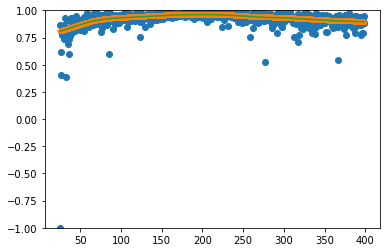

In [10]:
def evaluate_with_linear_model(data, n, actual_mal, mal, cv_fraction, optimal_param):
    mal_results = []
    ground_truth = []
    for i in range(n):
        training_i, testing_i = choose_training_indicies(data, math.ceil(data.shape[0] * cv_fraction))
        training_fold, testing_fold = split_data(data, training_i, testing_i)
        repeat_length_training = np.matrix([mal[i] for i in training_i]).reshape(-1, 1)
        repeat_length_testing = np.matrix([actual_mal[i] for i in testing_i]).reshape(-1, 1)

        top_genes = order_indicies(repeat_length_training, training_fold)[:optimal_param]
        training_set = choose_top_genes(top_genes, training_fold)
        testing_set = choose_top_genes(top_genes, testing_fold)

        shitty_linear_regression = sklearn.linear_model.LinearRegression()
        shitty_linear_regression.fit(training_set, repeat_length_training)
        scores = shitty_linear_regression.predict(testing_set)
        #print(scores.reshape(-1))
        mal_results.extend(scores.reshape(-1))
        ground_truth.extend(repeat_length_testing.reshape(-1).tolist()[0])
    return ground_truth, mal_results

In [11]:
def data_ISEs(data, optimal_param):
    mal_var = np.array(mal).reshape(-1, 1)

    top_genes_all = [i[1] for i in order_indicies(mal_var, data)[:optimal_param]]
    filtered_data = data[..., top_genes_all]
    errors = []


    for i in range(filtered_data.shape[1]):
        for_ise = sklearn.linear_model.LinearRegression()
        for_ise.fit(mal_var, filtered_data[..., i].reshape(-1, 1))
        #help(for_ise.fit)
        #print(mal_var)
        #print(for.ise_predict_mal)
        error = filtered_data[..., i].reshape(-1, 1) - for_ise.predict(mal_var)
        errors.append(error)

    errors = np.hstack(errors)

    ISEs = []
    for i in range(errors.shape[0]):
        ISEs.append(np.mean(errors[i, ...]))


    corrected_data = data - np.vstack([ISEs for i in range(data.shape[1])]).T
    return corrected_data

In [12]:
def mal_ISEs(data, optimal_param):
    mal_var = np.array(mal).reshape(-1, 1)
    
    top_genes_all = [i[1] for i in order_indicies(mal_var, data)[:optimal_param]]

    filtered_data = data[..., top_genes_all]
    errors = []

    for i in range(filtered_data.shape[1]):
        for_ise = sklearn.linear_model.LinearRegression()
        gene_data = filtered_data[..., i].reshape(-1, 1)
        for_ise.fit(gene_data, mal_var)
        #help(for_ise.fit)
        #print(mal_var)
        #print(for.ise_predict_mal)
        y = for_ise.predict(gene_data)
        #print(sklearn.metrics.r2_score(mal_var, ))
        error = mal_var - for_ise.predict(gene_data)
        errors.append(error)

    errors = np.hstack(errors)

    #print(errors.shape)

    ISEs = []
    for i in range(errors.shape[0]):
        ISEs.append(np.mean(errors[i, ...]))

    ISEs = np.array(ISEs).reshape(-1, 1)

    corrected_mal = mal_var - ISEs

    return corrected_mal

In [14]:
def produce_plot(ground_truth, mal_results, color, description):
    iis = []
    rs = []
    for i in range(2, len(mal_results), 10):
        r = sklearn.metrics.r2_score(mal_results[:i], ground_truth[:i])
        iis.append(i)
        rs.append(r)
    print(description, color, r)
    plt.scatter(iis, rs, color=color)

In [27]:
ISE_size = 300
sequence_randomness = 0.6
n_people = 30
n_genes = 2*10**3
n_active_genes = 200

186
known ISEs b 0.9115376284127115
ISEs without correction r 0.8473218574437158
ISEs using Darren's method y 0.8504311283636741
ISEs using Adam's method g 0.7562574989504296
corrected vs actual 0.804689385250052
mal vs actual 0.8182809655914507


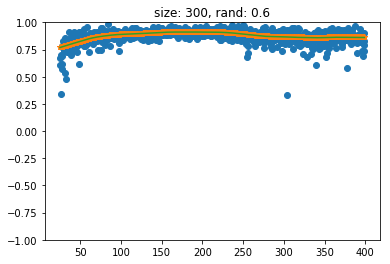

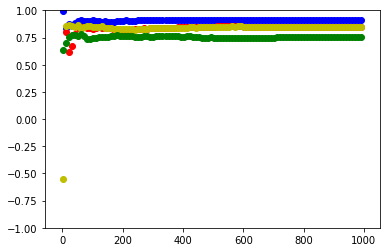

In [29]:
plt.figure()
plt.title("size: {}, rand: {}".format(ISE_size, sequence_randomness))
f_name = generate_dataset(ISE_size = ISE_size, sequence_randomness = sequence_randomness, n_people = n_people, n_genes = n_genes, n_active_genes = n_active_genes)
mal, actual_mal, data = load_data_set(f_name)
corrected_data = data_ISEs(data, optimal_param)
optimal_param = select_features(data, actual_mal, 25, 400)
plt.figure()
k = 100
plt.ylim([-1, 1])
cv = 0.66
produce_plot(*evaluate_with_linear_model(data, k, actual_mal, actual_mal, cv, optimal_param), "b", "known ISEs")
produce_plot(*evaluate_with_linear_model(data, k, actual_mal, mal, cv, optimal_param), "r", "ISEs without correction")
produce_plot(*evaluate_with_linear_model(corrected_data, k, actual_mal, mal, cv, optimal_param), "y", "ISEs using Darren's method")
corrected_mal = mal_ISEs(data, optimal_param)
produce_plot(*evaluate_with_linear_model(data, k, actual_mal, corrected_mal, cv, optimal_param), "g", "ISEs using Adam's method")
print("corrected vs actual", sklearn.metrics.r2_score(corrected_mal, actual_mal))
print("mal vs actual", sklearn.metrics.r2_score(mal, actual_mal))